In [1]:
# @title Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, requests
import tarfile
%matplotlib inline


In [2]:
# @title Getting and Preparing data

N_SUBJECTS = 100
N_PARCELS = 360
TR = 0.72
HEMIS = ["Right", "Left"]
RUNS   = ['LR','RL']
N_RUNS = 2
EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
HCP_DIR = "./hcp_task"
if not os.path.exists(HCP_DIR):
    with tarfile.open(fname) as tfile:
      tfile.extractall('.')
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [3]:
# @title Helper Functions

def load_single_timeseries(subject, experiment, run, remove_mean=True):
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
    ts /= ts.std(axis=1, keepdims=True) # we are doing z-score normalization (this line isn't there in NMA notebook)
  return ts

def load_evs(subject, experiment, run, exp_type):
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    if exp_type=="complete":
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    else:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{exp_type}_{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))

    start = np.floor(ev["onset"] / TR).astype(int)

    duration = np.ceil(ev["duration"] / TR).astype(int)

    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx])-1)], axis=-1), axis=1)

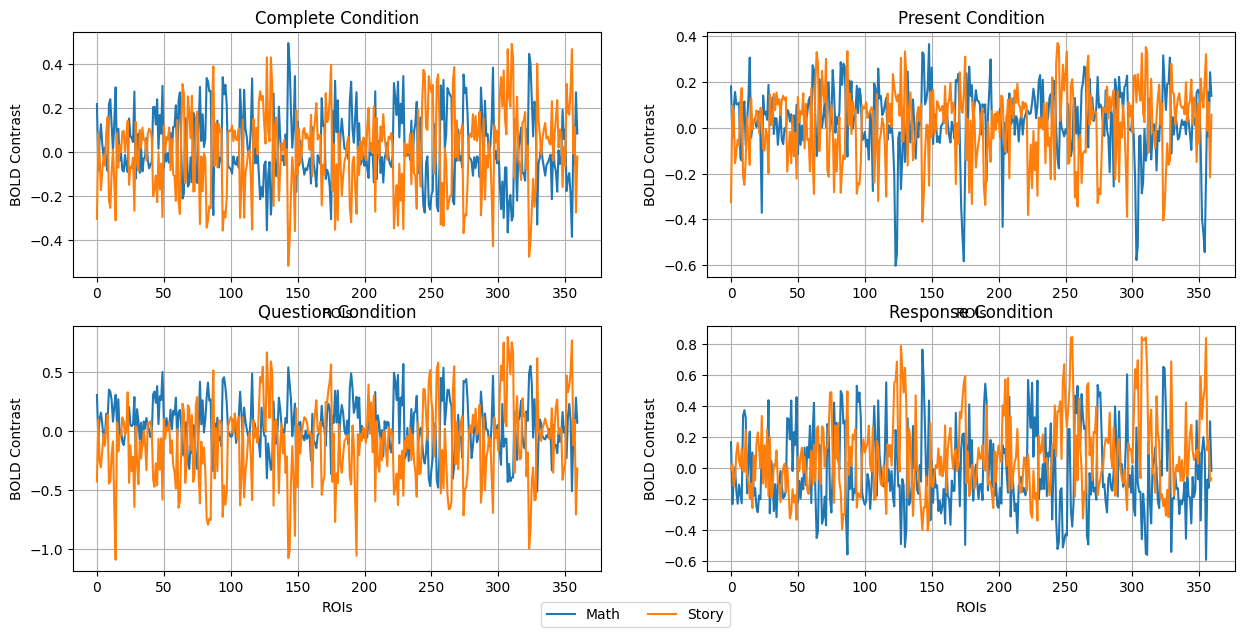

In [4]:
# @title Averaging and Plotting Relevant Contrasts

my_exp = "LANGUAGE"
my_cond = ["math","story"]
exp_types=["complete","present","question","response"]
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(len(exp_types)):
    cond1=[]
    cond2=[]
    group_contrast = 0
    for s in subjects:
        for r in [0, 1]:
            data = load_single_timeseries(subject=s, experiment=my_exp,
                                        run=r, remove_mean=True)
            evs = load_evs(subject=s, experiment=my_exp,run=r, exp_type=exp_types[i])

            cond1_activity = average_frames(data, evs, my_exp, my_cond[0])
            cond2_activity = average_frames(data, evs, my_exp, my_cond[1])
            cond1.append(cond1_activity)
            cond2.append(cond2_activity)
            contrast = cond1_activity - cond2_activity
            group_contrast += contrast
    group_contrast /= (len(subjects)*2)
    cond1 = np.array(cond1)
    cond2 = np.array(cond2)
    axs[i].plot(np.mean(cond1,axis=0),label='math')
    axs[i].plot(np.mean(cond2,axis=0),label='story')
    axs[i].set_title(f'{exp_types[i].capitalize()} Condition')
    axs[i].set_xlabel('ROIs')
    axs[i].set_ylabel('BOLD Contrast')
    axs[i].grid(True)
fig.legend(['Math',"Story"], loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2)

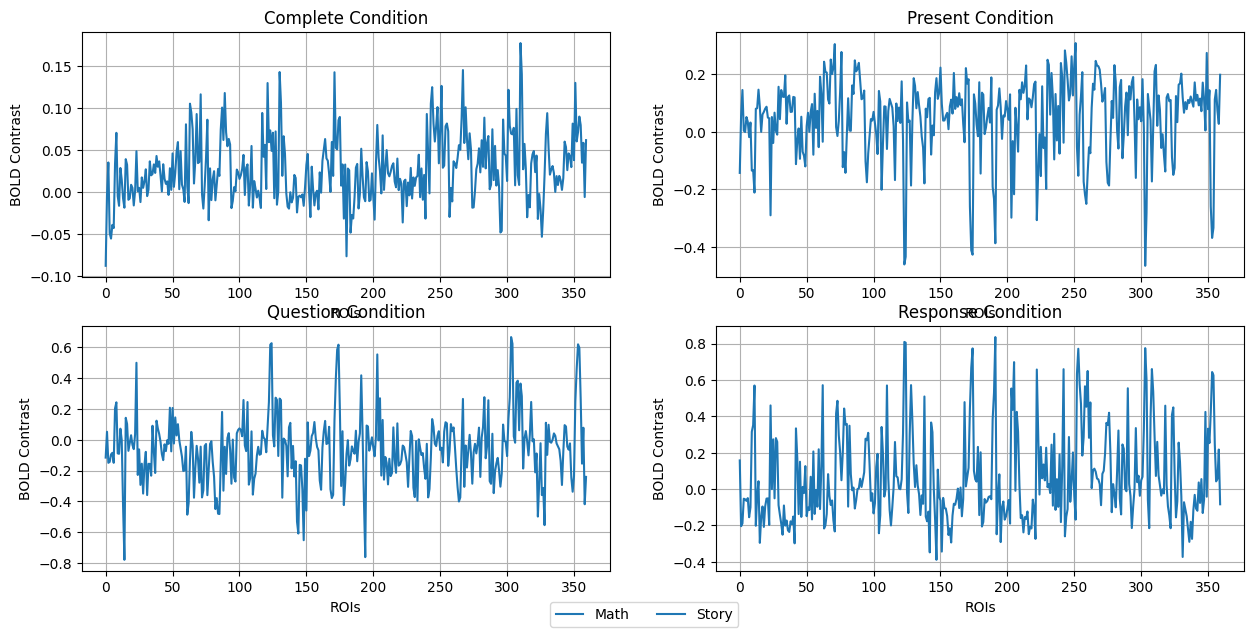

In [5]:
# @title Averaging and Plotting Relevant Contrasts - Do observe that contrast is calculated as (cond1 "+" cond2) to demonstrate that they are not arithmetic inverses of each other even though the amplitudes in Complete Condition are much smaller

my_exp = "LANGUAGE"
my_cond = ["math","story"]
exp_types=["complete","present","question","response"]
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.ravel()
for i in range(len(exp_types)):
    cond1=[]
    cond2=[]
    group_contrast = 0
    for s in subjects:
        for r in [0, 1]:
            data = load_single_timeseries(subject=s, experiment=my_exp,
                                        run=r, remove_mean=True)
            evs = load_evs(subject=s, experiment=my_exp,run=r, exp_type=exp_types[i])

            cond1_activity = average_frames(data, evs, my_exp, my_cond[0])
            cond2_activity = average_frames(data, evs, my_exp, my_cond[1])
            contrast = cond1_activity + cond2_activity
            group_contrast += contrast
    group_contrast /= (len(subjects)*2)
    axs[i].plot(group_contrast,label='contrast')
    axs[i].set_title(f'{exp_types[i].capitalize()} Condition')
    axs[i].set_xlabel('ROIs')
    axs[i].set_ylabel('BOLD Contrast')
    axs[i].grid(True)
fig.legend(['Math',"Story"], loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2)